In [55]:
import imp
compomics_import = imp.load_source('compomics_import', 'compomics_import.py')
from IPython.core.display import HTML
css_file = 'my.css'
HTML(open(css_file, "r").read())

# Regression

Tracking Parkinson's disease symptom progression often uses the unified Parkinson's disease rating scale (UPDRS) that requires the patient's presence in clinic, and time-consuming physical examinations by trained medical staff. Thus, symptom monitoring is costly and logistically inconvenient for patient and clinical staff alike, also hindering recruitment for future large-scale clinical trials. 

In 2010 a data set was published [1] that was composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. 


> [1] A. Tsanas, M. A. Little, P. E. McSharry, L. O. Ramig (2010),
*Accurate telemonitoring of Parkinson's disease progression by non-invasive 
speech tests*,
IEEE Transactions on Biomedical Engineering;57(4):884-93.

Let's see if we can create an accurate predictor of UPDRS from the voice measurements. Load the data set "parkinsons_updrs.csv" in a Pandas DataFrame called `data`.

In [56]:
import pandas as pd

data = pd.read_csv("parkinsons_updrs.csv")

What is the shape of the data set?

In [57]:
data.shape

(5875, 20)

The target column for the regression analysis is 'motor_UPDRS'. Plot the distribution of the values of this target column using the python `seaborn` package.

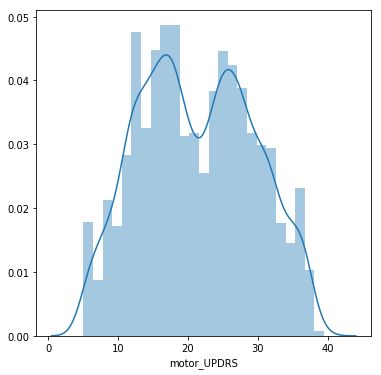

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.distplot(data['motor_UPDRS'])
plt.show()

Remove the "motor_UPDRS" column from the data set and assign it to a variable called `target`.

In [59]:
target = data.pop('motor_UPDRS')

Investigate the distribution of the features by plotting them as boxplots (use the Pandas `boxplot()` function).

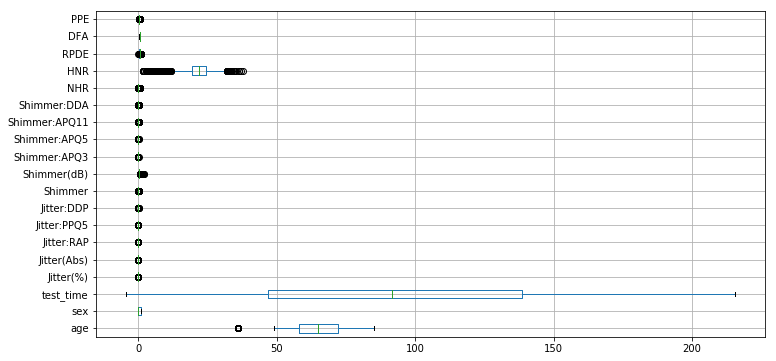

In [60]:
plt.figure(figsize=(12,6))
data.boxplot(vert=False)
plt.show()

You should see that the features have values at very different scales. To obtain more informative boxplots we can scale all the features to [0,1]. Use the sklearn `MinMaxScaler()` object to scale the features  (create a new DataFrame called `data_norm`). Then plot the distribution of the feature values again using a boxplot.

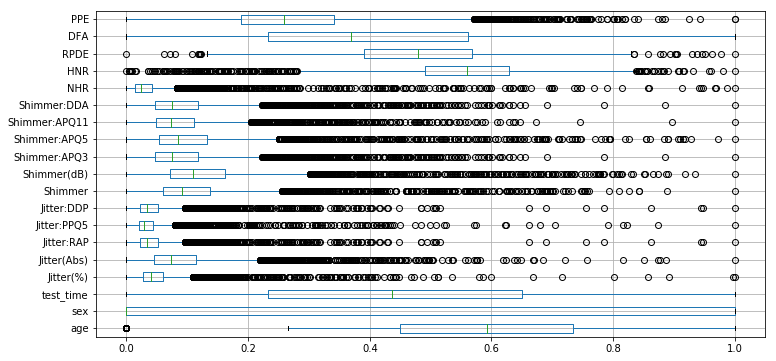

In [61]:
from sklearn.preprocessing import MinMaxScaler

data_norm = pd.DataFrame(MinMaxScaler().fit_transform(data),columns=data.columns.values)

plt.figure(figsize=(12,6))
data_norm.boxplot(vert=False)
plt.show()

Now we can see the boxplots much better. Plot a histogram of the feature 'Shimmer'.

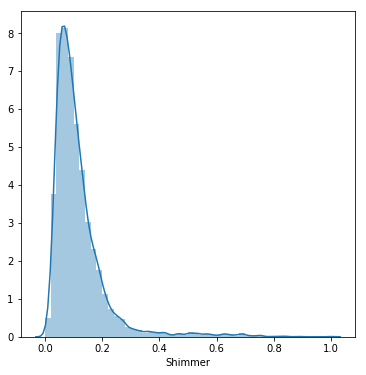

In [62]:
plt.figure(figsize=(6,6))
sns.distplot(data_norm['Shimmer'])
plt.show()

Notice how this distribution has a long tail on the right. It is sometimes useful to transform the feature values to remove this tail. Let's see if this is true for our data set. Train a linear model on this data using the `LinearRegression` module in scikit-learn. What is the $R^2$ performance of the regression model on the data set (so how well does the linear model fit the full data set)?

In [63]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(data_norm,target)

print "R-squared = %f" % metrics.r2_score(target,model.predict(data_norm))

R-squared = 0.156822


Now we will transform some of the features to remove their tails and see if there is a difference. One way to transform a feature with a long tail is to use the $log_2$ function.

In [64]:
import numpy as np

Shimmer_log2 = np.log2(data_norm['Shimmer']+0.01)

Notice how we added 0.01 to the column before taking the log to prevent taking the log of zero. Plot a histogram of the variable `Shimmer_log2`.

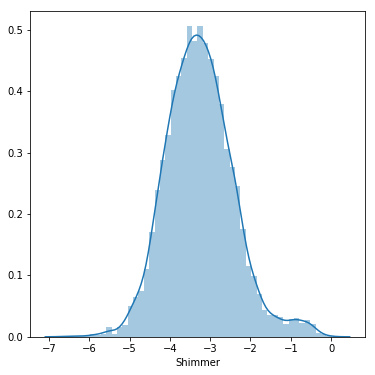

In [65]:
plt.figure(figsize=(6,6))
sns.distplot(Shimmer_log2)
plt.show()

Now we have a much more symmetrical distribution. There are more columns with long tails. Create a Pandas DataFrame `data_norm_log2` that is a copy of `data_norm`. Use a `for` loop to $log_2$ transform the feature values in `data_norm_log2` listed in the python list `to_log_scale` declared below.

In [66]:
to_log_scale= ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer(dB)',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA','Shimmer','NHR','PPE']

data_norm_log2 = data_norm.copy()

for c in to_log_scale:
    data_norm_log2[c] = np.log2(data_norm_log2[c]+0.01)

Again, plot a boxplot of the features in `data_norm_log2`.

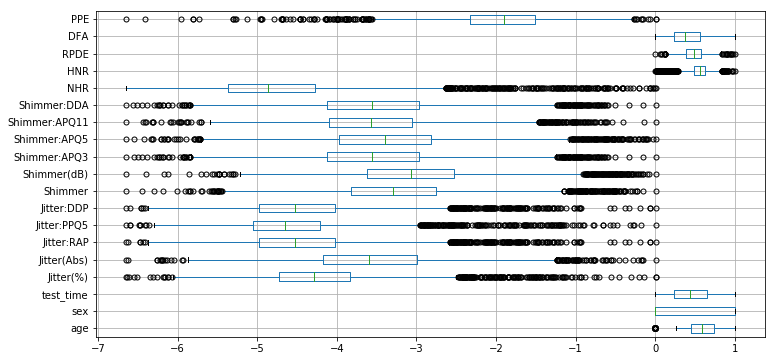

In [67]:
plt.figure(figsize=(12,6))
data_norm_log2.boxplot(vert=False,flierprops=dict(marker='o', markersize=5))
plt.show()

Now use the `StandardScaler` module in the sklearn package standardize the features in `data_norm_log2` and plot the boxplots of the features.

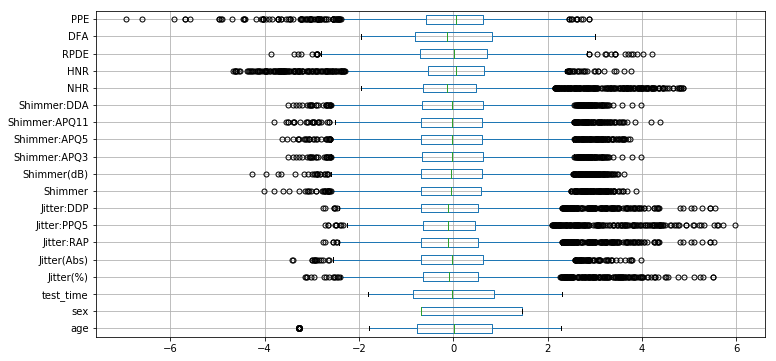

In [68]:
from sklearn.preprocessing import StandardScaler

data_norm_log2 = pd.DataFrame(StandardScaler().fit_transform(data_norm_log2),columns=data.columns.values)

plt.figure(figsize=(12,6))
data_norm_log2.boxplot(vert=False,flierprops=dict(marker='o', markersize=5))
plt.show()

Fit the model `LinearRegression` model again. How well does it fit this data set now? Do we get a better fit?

In [69]:
model.fit(data_norm_log2,target)

print "R-squared = %f" % metrics.r2_score(target,model.predict(data_norm_log2))

R-squared = 0.180518


We can investigate the predictions further by looking at the correlation between the target 'motor_UPDRS' and the predictions. Use the `seaborn` function `lmplot()` to plot the target against the predictions.

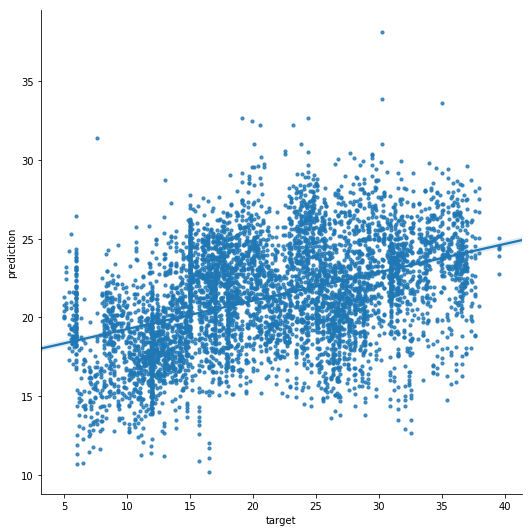

In [70]:
import seaborn as sns

model.fit(data_norm_log2,target)

tmp = pd.DataFrame()
tmp['target'] = target
tmp['prediction'] = model.predict(data_norm_log2)

sns.lmplot(x="target", y="prediction", data=tmp, size=7.5, scatter_kws={"s": 10})
plt.show()

Now we will split the data sets into a train and a test at random by creating a list "folds" that contains random values zero and one. 

In [71]:
import numpy as np

np.random.seed(1234)

folds = np.random.randint(2,size=len(data_norm_poly))

Fit a Linear Regression model on data set `data_norm` for the rows where folds==0.

In [72]:
model.fit(data_norm[folds==0],target[folds==0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

What is the $R^2$ performance on the part where folds==1 (test set)?

In [73]:
print "R-squared = %f" % metrics.r2_score(target[folds==1],model.predict(data_norm[folds==1]))

R-squared = 0.152817


Fit a Linear Regression model on data set `data_norm_log2` for the rows where folds==0.

In [74]:
model.fit(data_norm_log2[folds==0],target[folds==0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

What is the $R^2$ performance on the part where folds==1 (test set)?

In [75]:
print "R-squared = %f" % metrics.r2_score(target[folds==1],model.predict(data_norm_log2[folds==1]))

R-squared = 0.175325
